# Classifying game genres based on game descriptions
The goal is to use short (170 character) description of games to classify them as 1 og 31 game genres. The idea is that it should be possible to get a broad overview of what kind og game it is by reading the description. Let's have a few example:

>a game of exploration and survival in an epic fantasy setting

>A physics based game with 100 levels of challenging fun

>Welcome to the next-generation of open-world gaming

>The long awaited second expansion to Blizzards critically acclaimed RTS

>A Pay2Win business model simulator(adventure) that exposes the tricks online game businessmen use to maximize monetizatio

This illustrages some of the benifits and challanges of the dataset. Let's have a look at the 31 genres:

1. Action
2. Indie
3. Strategy
4. Early Access
5. Free to Play
6. Massively Multiplayer
7. RPG
8. Adventure
9. Casual
10. Simulation
11. Racing
12. Sports
13. **Audio Production**
14. **Utilities**
15. **Video Production**
16. **Education**
17. **Design & Illustration**
18. **Web Publishing**
19. **Photo Editing**
20. **Software Training**
21. **Animation & Modeling**
24. Puzzle
25. Platformer
26. Survival
27. Shooter
28. Horror
29. Sandbox
30. **Music**
31. Fighting
32. Hidden Objects
33. **Accounting**

Quite a lot of these (11 ~ 1/3) are not actually games. That is because Steam sell application that are not games.

In [1]:
genre_names = ['Action', 'Indie', 'Strategy', 'Early Access', 'Free to Play', 'Massively Multiplayer', 'RPG',
               'Adventure', 'Casual', 'Simulation', 'Racing', 'Sports', 'Audio Production', 'Utilities', 
               'Video Production', 'Education', 'Design & Illustration', 'Web Publishing', 'Photo Editing',
               'Software Training', 'Animation & Modeling', 'Puzzle', 'Platformer', 'Survival', 'Shooter', 
               'Horror', 'Sandbox', 'Music', 'Fighting', 'Hidden Objects', 'Accounting']

To do this we will be using the sklearn python package. It is an extremely useful machine learning package that will allow us to build a powerfull classifier in just a couple of lines. The disadvantage of this package is that it makes it possible to build, very quickly, something that you don't understand. At best it is a problem solver, at worst it is a black box generator.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone

from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from cycler import cycler

%matplotlib inline

## Getting and loading the data
The raw data are psql dumps from the homepage www.arcatetrail.com. The site is not longer active. 

The raw data is loaded using custom loading functions. 

In [3]:
import src.ReccomenderSystem as RC

titles = RC.reading_titles('data/game_titles.csv')
genres, num_games, num_attributes = RC.reading_votes('data/game_genres.csv')
id, taglines = RC.reading_taglines('data/game_tagline.csv')

For example, one of the taglines is the following:

In [4]:
print(taglines[1])

a game of exploration and survival in an epic fantasy setting



## Restructuring the data
Before we can use scikit-learn to build a classifier, we must make sure that the data is structured in a way scikit-learn will accept.

The classifier will take a string as imput and produce a numerical genre index. Below I make a list of all the game tags and a corresponding vector contining all the genre indices.

In [5]:
y_mat = np.zeros((len(id),32))
X_mat = []
X_titles = []
kk = 0;
for ii in range(0,len(id)):
    tagline_index = np.where(genres[:,0]==int(id[ii]))
    if len(tagline_index[0])>0:
        X_mat.append(taglines[ii])
        for jj in range(0,len(tagline_index[0])):
            genre = int(genres[tagline_index[0][jj],1])
            y_mat[kk,genre-1] = 1
    else:
        X_mat.append(taglines[ii])
    kk = kk+1

## Exploring the data
Before I build the classifier, I it is usefull to explore the data to get a realistic expection about how successful the classifier can be. Below I look at how the games are distributed across the different genres.

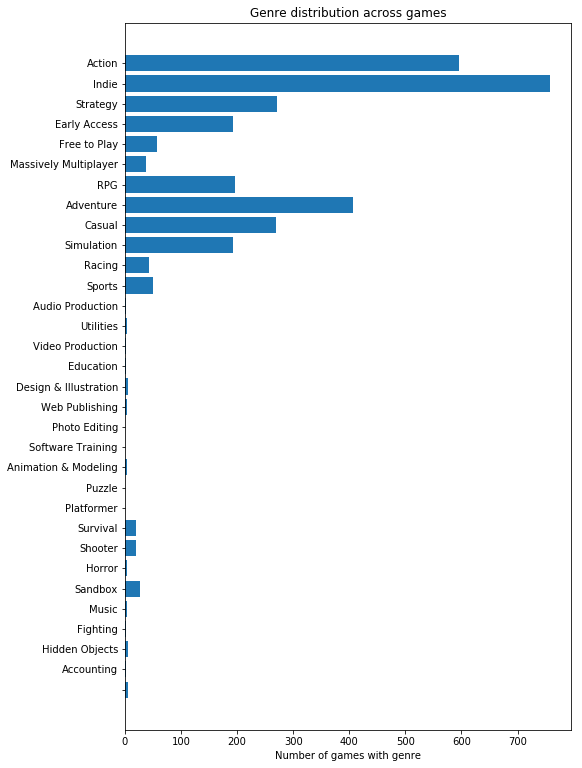

In [62]:
aggregate = sum(y_mat)
fig, ax = plt.subplots(figsize=(8,13))
ax.barh(range(0,32), aggregate)
ax.set_yticks(range(0,32))
ax.set_yticklabels(genre_names);
ax.set(title='Genre distribution across games', xlabel='Number of games with genre')
ax.invert_yaxis()


Many of the genres are empty. That is, there are no games with that genre. There are also quite a few of the genres that have less than 50 games in them. It will be difficult to build a good classifier for there.

## Splitting into train and test sets

In [7]:
train_size = int(round(len(y_mat)*0.8))
genre_to_train = 0
y_train = y_mat[:train_size, genre_to_train]
X_train = X_mat[:train_size]
X_test = X_mat[train_size:];
y_test = y_mat[train_size:, genre_to_train];

## Doing the pre-processing

In [8]:
X_train[0]

'A science fiction action role-playing third person shooter video game developed by BioWare and published by Electronic Arts.\n'

### Going from strings to vectors (Vectorizer)

In [9]:
tfid_vectorizer = TfidfVectorizer(X_train,
                stop_words='english',analyzer='word')

The stop words the model ignors can be inspected:

In [40]:
tfid_vectorizer.get_stop_words();

Likewise, the strings used to build the analyzer can be inspected togeter with the parameters of the model

In [11]:
tfid_vectorizer.get_params();

So lets see how it works by running it over an example and doing the inverse transform to get the words it used back

In [12]:
X_vect = tfid_vectorizer.fit_transform([X_test[0]])

In [13]:
X_inverse = tfid_vectorizer.inverse_transform(X_vect)

So the test example gets the following transform:

In [14]:
print('before: ' + X_test[0])
print('After: ' + str(X_inverse[0][:]))

before: A fast and skill based party game where all of the focus lies in fun and engaging gameplay

After: ['fast' 'skill' 'based' 'party' 'game' 'focus' 'lies' 'fun' 'engaging'
 'gameplay']


## Lemmatizing

In [15]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [16]:
tfid_vectorizer = TfidfVectorizer(X_train,
                    tokenizer=LemmaTokenizer(), 
                    stop_words='english',analyzer='word')


In [17]:
X_vect = tfid_vectorizer.fit_transform([X_test[0]])
X_inverse = tfid_vectorizer.inverse_transform(X_vect)
print('before: ' + X_test[0])
print('After: ' + str(X_inverse[0][:]))

before: A fast and skill based party game where all of the focus lies in fun and engaging gameplay

After: ['fast' 'skill' 'based' 'party' 'game' 'focus' 'lie' 'fun' 'engaging'
 'gameplay']


### Normalizing with term-frequency-inverse-document-frequency

In [18]:
tfidf_normalizer = TfidfTransformer(norm='l2',use_idf=False,smooth_idf=False)

In [19]:
X_vect_norm = tfidf_normalizer.fit_transform(X_vect)

In [20]:
print(X_vect_norm)

  (0, 2)	0.316227766017
  (0, 9)	0.316227766017
  (0, 0)	0.316227766017
  (0, 8)	0.316227766017
  (0, 5)	0.316227766017
  (0, 3)	0.316227766017
  (0, 7)	0.316227766017
  (0, 4)	0.316227766017
  (0, 1)	0.316227766017
  (0, 6)	0.316227766017


## Setting up the pipeline

In [21]:
pipeline = Pipeline([
('vect', TfidfVectorizer(X_train, stop_words='english', analyzer='word', tokenizer=LemmaTokenizer())),
('tfidf', TfidfTransformer(norm='l2',use_idf=False, smooth_idf=False)),
('clf', LogisticRegression(C=1))
])
clf = pipeline.fit(X_train, y_train)
# Other classifiers I have tried:
# MultinomialNB
# AdaBoostClassifier, RandomForestClassifier
# SGDClassifier

## Testing the performance

In [22]:
model_test_collection = []
for genre in range(0,12): #31
    clf_clone = clone(pipeline)
    clf_clone.fit(X_train, y_mat[:train_size, genre])
    model_test_collection.append(clf_clone)

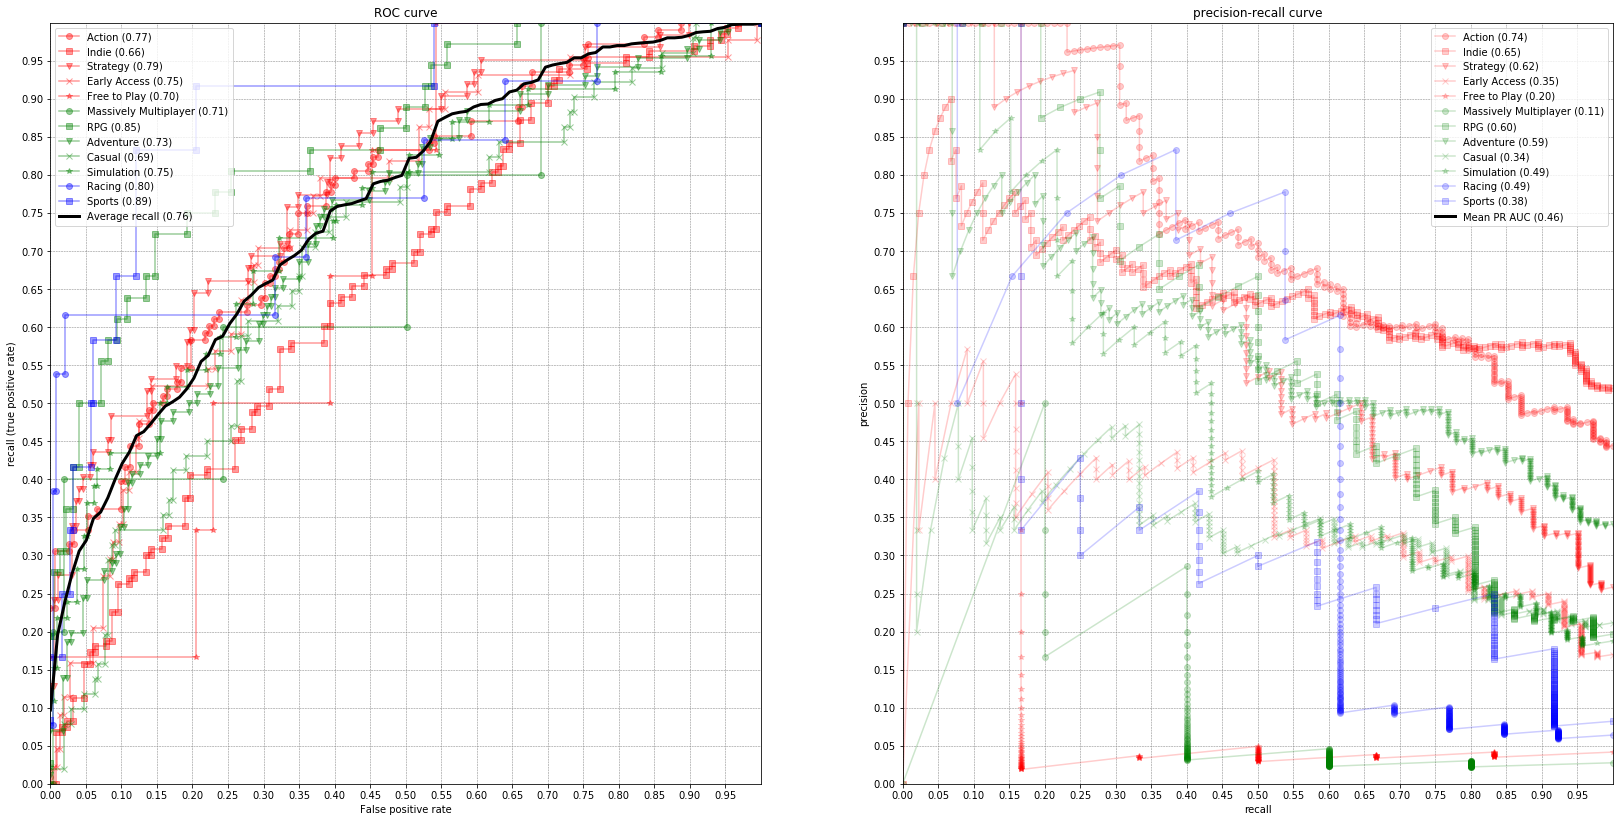

In [23]:
# Setting up the color-marker cycle
color_cycle = cycler(color=['r', 'g', 'b', 'c', 'm', 'k', 'y'])
marker_cycle = cycler(marker=['o', 's', 'v', 'x','*'])
cycle = color_cycle * marker_cycle

# Initializing the figure handles
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(28,14))

# Initializing
aggregate_tpr = 0.0
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)


aggregate_roc_auc = 0
aggregate_pr_auc = 0

# Helper functions 
def ticks_and_gridlines(ax):
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.0])
    ax.set(xticks=np.arange(0,1,0.05), yticks=np.arange(0,1,0.05))
    ax.grid(color='gray', linestyle='--', linewidth=.5, which='major');

# Looping over the models
for idx, (model, sty) in enumerate( zip(model_test_collection[0:12], cycle)):
    if np.sum(y_mat[train_size:, idx] > 0):
        # Making the prediction
        y_score = model.predict_proba(X_test)
        
        # Calculating false and true positive rate
        fpr, tpr, threshold = metrics.roc_curve(y_mat[train_size:, idx], y_score[:, 1])
        roc_auc = metrics.auc(fpr, tpr)
        aggregate_tpr += np.interp(mean_fpr, fpr, tpr)
        
        # Calculating precision and recall
        precision, recall, threshold = metrics.precision_recall_curve(y_mat[train_size:, idx], y_score[:, 1]);
        pr_auc = metrics.auc(recall, precision)
        aggregate_pr_auc += pr_auc 
        
        # Plotting the metrics
        ax0.plot(fpr, tpr, **sty, alpha=.4, label='{0} ({1:.2f})'.format(genre_names[idx], roc_auc))
        ax1.plot(recall, precision, **sty, alpha=.2, label='{0} ({1:.2f})'.format(genre_names[idx], pr_auc))

# Plotting the average metrics
mean_tpr = np.divide(aggregate_tpr, (idx+1))
mean_roc_auc = metrics.auc(mean_fpr, mean_tpr)
mean_pr_auc = aggregate_pr_auc/(idx+1)

ax0.plot(mean_fpr, mean_tpr, lw=3, color='k', label='Average recall ({0:.2f})'.format(mean_roc_auc))
ax1.plot(1,1, lw=3, color='k', label='Mean PR AUC ({0:.2f})'.format(mean_pr_auc))

# Setting up labels and axis for ax0
ax0.set(xlabel='False positive rate', ylabel='recall (true positive rate)',
      title='ROC curve')
ax0.legend(loc="upper left")
ticks_and_gridlines(ax0)

# Setting up labels and axis for ax1
ax1.set(xlabel='recall', ylabel='precision', title='precision-recall curve')
ax1.legend(loc="upper right")
ticks_and_gridlines(ax1)
    

The figure below shows how the interpolation does not work.

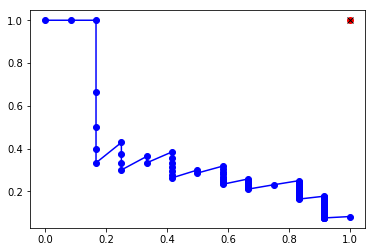

In [24]:
#aggregate_precision += np.interp(mean_recall, recall, precision)
from scipy import interp
x_p = 1
y_p = np.interp(x_p, recall, precision)
y_p_scipy = interp(x_p, recall, precision)
plt.figure()
plt.plot(recall, precision, '-ob')
plt.plot(x_p, y_p, 'or')
plt.plot(x_p, y_p_scipy, 'xk')

## Optimizing the LogistirRegression using Grid Search

To get the full list of hyper parameters that are tunable in the entire pipeline, I run the following code:

In [25]:
pipeline.get_params().keys()

dict_keys(['steps', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__norm', 'vect__preprocessor', 'vect__smooth_idf', 'vect__stop_words', 'vect__strip_accents', 'vect__sublinear_tf', 'vect__token_pattern', 'vect__tokenizer', 'vect__use_idf', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

Of these I select a few that seem reasonable and run a grid search on those

In [26]:
param_grid = [
    {'vect__stop_words': ['english', None], 'vect__tokenizer': [LemmaTokenizer(), None],
     'tfidf__use_idf': [False, True], 'tfidf__smooth_idf': [False, True],
     'tfidf__norm': ['l1', 'l2', None],
     'clf__C': [0.5, 1, 5, 10]
    }
]

pipeline_clone = clone(pipeline)
grid_search = GridSearchCV(pipeline_clone, param_grid, cv=5)
grid_search.fit(X_train, y_mat[:train_size, 0]);

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8',
        input=['A science fiction action role-playing third person shooter video game developed by BioWare and published by Electronic Arts.\n', 'a game of exp...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'vect__stop_words': ['english', None], 'vect__tokenizer': [<__main__.LemmaTokenizer object at 0x11287c828>, None], 'tfidf__use_idf': [False, True], 'tfidf__smooth_idf': [False, True], 'tfidf__norm': ['l1', 'l2', None], 'clf__C': [0.5, 1, 5, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

To get the best parameters I run the following code:

In [27]:
grid_search.best_params_

{'clf__C': 1,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': False,
 'tfidf__use_idf': False,
 'vect__stop_words': 'english',
 'vect__tokenizer': None}

In [28]:
grid_search.best_score_

0.69297401347449472

## Understanding the models

## Trying out a few made-up examples

In [29]:
model_collection = []
for genre in range(0,12): #31
    clf_clone = clone(pipeline)
    clf_clone.fit(X_mat, y_mat[:, genre])
    model_collection.append(clf_clone)

In [30]:
example = ['Shoot your way through the jungle to survive']

In [31]:
pred_list = []
for idx, clf in enumerate(model_collection):
    pred = clf.predict_proba(example)
    pred_list.append(pred[:,1])

In [32]:
sort_idx = sorted(range(len(pred_list)), key=lambda k: pred_list[k], reverse=True)
my_list = [(pred_list[idx], genre_names[idx]) for idx in sort_idx]
my_list

[(array([ 0.66913245]), 'Action'),
 (array([ 0.66120181]), 'Indie'),
 (array([ 0.28398323]), 'Adventure'),
 (array([ 0.20654147]), 'Casual'),
 (array([ 0.14401607]), 'RPG'),
 (array([ 0.12895352]), 'Strategy'),
 (array([ 0.12618321]), 'Simulation'),
 (array([ 0.12338402]), 'Early Access'),
 (array([ 0.05086056]), 'Sports'),
 (array([ 0.04410804]), 'Free to Play'),
 (array([ 0.02953413]), 'Massively Multiplayer'),
 (array([ 0.02647476]), 'Racing')]

## Cool applications of the classifier described above
- classify.me: A website that classifies a game given a tagline.
- tagline generator: One could run the algorithm in reverse. Given a genre, generate a tagline. I'm not entirely sure how one would do this. The idea is to get some of the top keywords from a genre and then use those to generate a short description. I'm sure other people have worked with generating sentences string from keywords. See eg. [Narrative Science](#https://www.narrativescience.com/) 